<h1><center>Uniform sampling of a curve</center></h1>

Once for a job interview I was asked to find solution to the following sampling problem:

Assume a parametric curve in the (x, y) plane as a function of t with t in [0, 1]

Hence we have the following functions describing the curve:
x(t), y(t)

For example
x(t) = 20*t*sin(t/10),
y(t) = 3*exp(2*t)

Sample the curves in Python for an arbitrary x(t), y(t) in such a way that
- each segment between two adjacent points has equal length and
- the total length of the curve is accurate down to a specified maximum error.

The outcome should be:
- how many points N are required?
- the resampled functions in x(i), y(i), where i is an integer between 0 and N.

Feel free to check if there are modules that can be of help (this is not a suggestion that there are any).
It may help to take into account the local curvature to estimate the curve length.
Ideally the process is "fast", as there may be hundreds of curves in a design.


<h1><center>Solution</center></h1>
Steps to take:

1. We know that t is in [0, 1], but the first step is to find the upperlimit T <= 1 such that the curve length is equal to the desired length for t in [0, T].

2. Next we iteratively increase the number of samples for t in [0, T] such that every segment has the same size. With each iteration, check the total curve size realized which should be the same as desired within the specified error bound.

In [36]:
import numpy as np
import typing
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib inline

## Function definitions

In [55]:
def find_t_given_curve_len(
        curve_len_array:np.ndarray,
        ref_curve_len_array:np.ndarray,
        ref_t_array:np.ndarray
):
    """Return the t_array which corresponds to the given curve_len_array
    Args:
        curve_len_array: np.ndarray, numpy array containing curve's length increasing with each segment
        ref_curve_len: np.ndarray, numpy array containing the curve's length sampled over uniform t to interpolate on
        ref_t_array: np.ndarray, numpy array contianing parameters t which are uniformly sampled
    Returns:
        np.ndarray containing values of parameter t corresponding to curve_len_array
    """
    return np.interp(curve_len_array, ref_curve_len_array, ref_t_array)

def find_curve_len(
        x_t: typing.Callable,
        y_t: typing.Callable,
        t_array: np.ndarray,
)->np.ndarray:
    """Given the parametric functions, returns an np array containing increasing curve length for each segment
    Args:
        x_t: function, defines x(t)
        y_t: function, defines y(t)
        t_array: np.ndarray, parameter values to evaluate x(t) and y(t) on
    Returns:
        curve_len_array: np.ndarray, numpy array containing the curve's length increasing with each segment
    """
    # produce the curve for the given sample
    x, y = x_t(t_array), y_t(t_array)
    segment_len_array = np.zeros(t_array.size)
    segment_len_array[1:] = np.sqrt((x[1:] - x[:-1]) ** 2 + (y[1:] - y[:-1]) ** 2)
    curve_len_array = np.cumsum(segment_len_array)
    return curve_len_array

def find_upper_limit_T(
        x_t: typing.Callable,
        y_t: typing.Callable,
        target_curve_len: float
)->typing.Tuple[float, np.ndarray, np.ndarray]:
    """Determine the upper limit T such that t in [0, T] gives a curve length of target_curve_len
    Args:
        x_t: function that determines x(t)
        y_t: function that determines y(t)
        target_curve_len: float, desired length of the curve
    Returns:
        T: float, upper limit T in [0, T] for the parameter t that produces curve with given length
        curve_len_array: np.ndarray, array containing curve's length sampled for t in [0, 1]
        t_array: np.ndarray, array containing uniformly sampled parameter t in [0, 1]        
    """
    # create a fine sample of curve with t such that it adequately samples it
    t_array = np.linspace(0, 1, 10000)

    # calculate the curve length
    curve_len_array = find_curve_len(x_t, y_t, t_array)

    # finally we invert the curve_len_array to determine the upper-bound T of the parameter t
    T = np.interp(target_curve_len, curve_len_array, t_array)
    return T, curve_len_array, t_array

def myplot(
    x:np.ndarray,
    y:np.ndarray,
    style:str = None,
    *,
    xlabel:str = None,
    ylabel:str = None,
    title:str = None,
    aspect:str = None
):
    """Function to produce plots according to my preferences"""
    fig, ax = plt.subplots(constrained_layout=True)
    if style is None:
        ax.plot(x, y, linewidth = 2)
    else:
        ax.plot(x, y, style, linewidth = 2)
            
    
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if title is not None:
        ax.set_title(title)
    if aspect is not None:
        ax.set_aspect(aspect)
    return fig, ax

# I like latex fonts, comment out this segment if it causes error during execution
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 16,
  "font.family": "Helvetica"
})
    

## Input parameters and the main body

In [59]:
#####################################input configuration#####################################

target_curve_len = 5 # desired length of the curve, it should be achievable for t in [0, 1]
t_interval = [0, 1] # interval of the parameter t (defined in the question)
error_bound = 1e-4 # error bound on the length of the realized curve
max_num_segments = 10000 # maximum number of curve sampling allowed to prevent the algorithm from running indefinitely

# define functions x(t) and y(t)
x_t = lambda t: 20*t*np.sin(t/10) # function x(t)
y_t = lambda t: 3*np.exp(t**2) # function y(t)

###################################end configuration###################################

# first we need to determine the parameter T such that t in [0, T] yields a curve whose size is target_curve_len
T, ref_curve_len_array, ref_t_array = find_upper_limit_T(x_t, y_t, target_curve_len)

# ensure that the returned curve has the same length as desired in the target_curve_len
if (ref_curve_len_array[-1] < target_curve_len):
    raise Exception("The desired curve length cannot be reached with t in [0, 1]")

# now we need to uniformly sample the curve such that its length is within the error bounds

output_curve_len = 0
num_segments = 0 # 1 segment means two points and so on
while (np.abs(output_curve_len - target_curve_len)/target_curve_len > error_bound):
    num_segments += 1
    curve_len_array = np.linspace(0, target_curve_len, num_segments+1)
    t_array = find_t_given_curve_len(curve_len_array, ref_curve_len_array, ref_t_array)
    curve_len_array = find_curve_len(x_t, y_t, t_array)
    output_curve_len = curve_len_array[-1]
#         print("segments = {}".format(num_segments))
    if (num_segments > max_num_segments):
        raise Exception("Maximum number of curve segments reached, stopping computation")


# now that we know T and num_segments, let us produce the output curve
print("Number of curve segments = {}, curve length = {}".format(t_array.size, output_curve_len))
x_out, y_out = x_t(t_array), y_t(t_array)

Number of curve segments = 9, curve length = 4.9995806972992005


## Plotting results

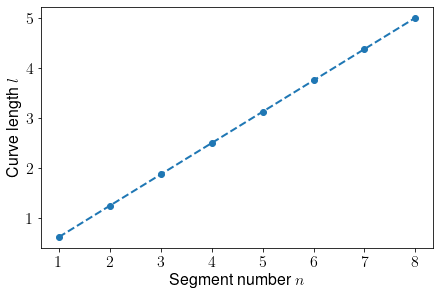

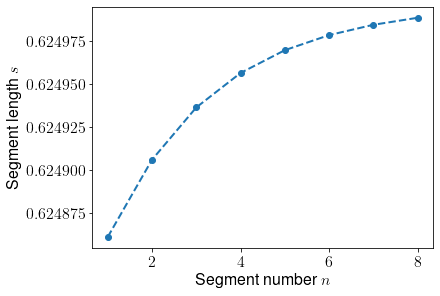

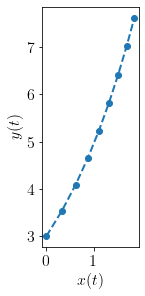

In [62]:
plot_settings = {
    "xlabel":"Segment number $n$",
    "ylabel":"Curve length $l$"
}

fig, ax = myplot(range(1, t_array.size), curve_len_array[1:],'o--', **plot_settings)

plot_settings["ylabel"] = "Segment length $s$"
fig, ax = myplot(range(1, t_array.size), curve_len_array[1:] - curve_len_array[:-1],'o--', **plot_settings)

plot_settings["xlabel"] = "$x(t)$"
plot_settings["ylabel"] = "$y(t)$"
plot_settings["aspect"] = "equal"
fig, ax = myplot(x_out, y_out, 'o--', **plot_settings)

## Final remarks

1. Considering the first figure, we see that the curve length increases linearly with increasing number of curve segments. This demonstrates that each segment is of equal length
2. Likewise, the second (i.e. middle) figure shows the size of each segment versus segment number. This too is identical up to 10^{-3}. This again confirms that we did a decent job.
3. Let us lastly consider the plot y(t) vs x(t). Note the figure has a skewed aspect ratio to ensure the grid shape is square. Otherwise, it's surprisingly easy to believe upon visual inspection that segment lengths are not equal. 

Lastly, the part where we determine the upper limit T can run into inaccuracies if x(t), y(t) have sufficiently fast oscillations. A better job at preventing that is possible by iteratively increasing sampling resolution for parameter t until the curve stabilizes. Perhaps some day if I have the motivation I will fix that part.